In [271]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)
from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["No conflict","Conflict"]

In [272]:
#url = 'https://data.kimetrica.com/dataset/4dbc3cc7-9474-49f2-bfd4-231e78401caa/resource/7423b71d-ce8c-437c-9fe6-2d9ba58d6155/download/dataset_communal_cnflict_model.csv'
df = pd.read_csv('/Users/yaredhurisa/Google Drive/Probability of conflict/indicators/eth_cc_final_dataset.csv')
list(df.columns)

['Unnamed: 0',
 'date',
 'group',
 'cc_onset_current',
 'fatalities_current',
 'cc_onset_lag',
 'fatalities_lag',
 'actor_state',
 'actor_rebel_groups',
 'actor_political_militias',
 'actor_identity_militias',
 'actor_civilians',
 'actor_others',
 'inflation_all',
 'rainfall',
 'temperature mean',
 'btotl',
 'maize_ETB_KG',
 'teff_ETB_KG',
 'wheat_ETB_KG',
 'mean ndvi',
 'fs_Crisis',
 'fs_Emergency',
 'fs_Famine',
 'fs_Minimal',
 'fs_Stressed']

In [273]:
df=df.drop(['fatalities_current'], axis=1)

In [274]:
#Training, and test 
start_date = "2009-12-01"
end_date = "2018-01-01"
mask = (df['date'] > start_date) & (df['date'] < end_date)
train = df.loc[mask]


start_date = "2017-12-01"
end_date = "2019-01-01"
mask = (df['date'] > start_date) & (df['date'] < end_date)
test = df.loc[mask]

In [275]:
# Remove time column, and the categorical columns
train = train.drop(['date', 'group'], axis=1)
test = test.drop(['date', 'group'], axis=1)

In [276]:
df_train_0 = train.loc[train['cc_onset_current'] == 0]
df_train_1 = train.loc[train['cc_onset_current'] == 1]
df_train_0_x = df_train_0.drop(['cc_onset_current'], axis=1)
df_train_1_x = df_train_1.drop(['cc_onset_current'], axis=1)

df_test_0 = test.loc[test['cc_onset_current'] == 0]
df_test_1 = test.loc[test['cc_onset_current'] == 1]
df_test_0_x = df_test_0.drop(['cc_onset_current'], axis=1)
df_test_1_x = df_test_1.drop(['cc_onset_current'], axis=1)

In [277]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(test.drop(['cc_onset_current'], axis = 1))

In [278]:
nb_epoch = 200
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 22)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 32)                736       
_________________________________________________________________
dense_77 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_78 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_79 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_80 (Dense)             (None, 22)                726       
Total params: 2,806
Trainable params: 2,806
Non-trainable params: 0
________________________________________________________

In [279]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_test_x_rescaled, df_test_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 5182 samples, validate on 660 samples
Epoch 1/200
5182/5182 [==============================] - 1s 120us/step - loss: 1.8825 - accuracy: 0.0133 - val_loss: 8.0053 - val_accuracy: 0.1106
Epoch 2/200
5182/5182 [==============================] - 0s 20us/step - loss: 1.4248 - accuracy: 0.0756 - val_loss: 6.0493 - val_accuracy: 0.2500
Epoch 3/200
5182/5182 [==============================] - 0s 19us/step - loss: 1.0629 - accuracy: 0.1202 - val_loss: 4.9144 - val_accuracy: 0.2455
Epoch 4/200
5182/5182 [==============================] - 0s 19us/step - loss: 0.8165 - accuracy: 0.2709 - val_loss: 4.1398 - val_accuracy: 0.5424
Epoch 5/200
5182/5182 [==============================] - 0s 18us/step - loss: 0.6700 - accuracy: 0.3640 - val_loss: 3.7010 - val_accuracy: 0.5227
Epoch 6/200
5182/5182 [==============================] - 0s 18us/step - loss: 0.5809 - accuracy: 0.3574 - val_loss: 3.5714 - val_accuracy: 0.5242
Epoch 7/200
5182/5182 [==============================] - 0s 18us/step - loss

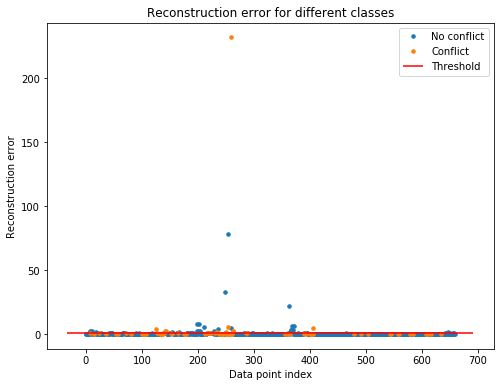

In [280]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test['cc_onset_current']})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Conflict" if name == 1 else "No conflict")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

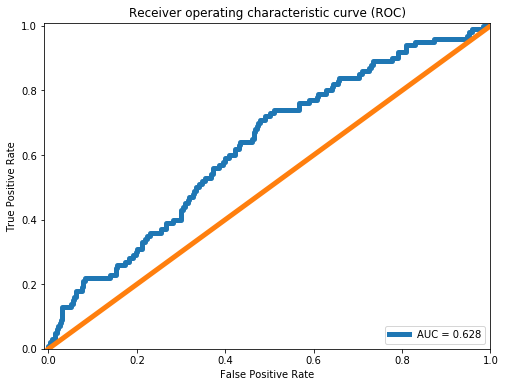

In [281]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

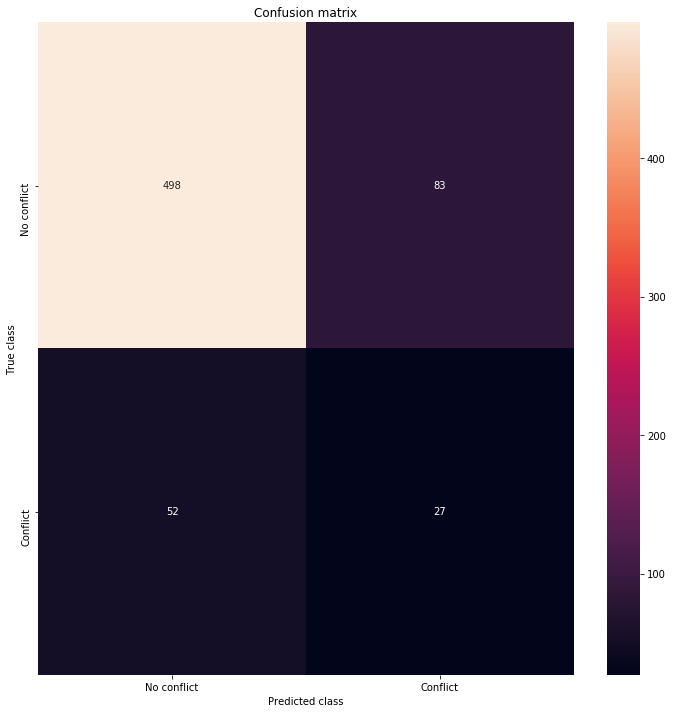

In [282]:
pred_y_test = [1 if e > threshold_fixed else 0 for e in error_df_test.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y_test)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [283]:
test_cc=test.cc_onset_current
pred_y_test=pd.DataFrame(pred_y_test)
print(classification_report(test_cc, pred_y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88       581
         1.0       0.25      0.34      0.29        79

    accuracy                           0.80       660
   macro avg       0.58      0.60      0.58       660
weighted avg       0.83      0.80      0.81       660

